In [1]:
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras

In [2]:
def imread(path):
    return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

In [3]:
paths = glob.glob('images/train/*/*.png')
len(paths)

18000

In [5]:
data_dir = 'manual'
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    zoom_range=0.2,
)
flow_params = {
    'class_mode': 'sparse',
    'color_mode': 'grayscale',
    'target_size': (128, 128),
#     'batch_size': batch_size,
}
test_it = datagen.flow_from_directory(data_dir, **flow_params)

Found 67 images belonging to 6 classes.


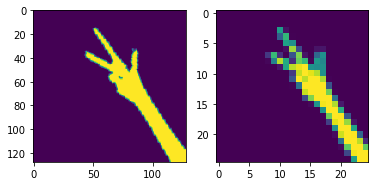

In [6]:
Xtrain, _ = test_it.next()
_, (ax1, ax2) = plt.subplots(1, 2)
X = Xtrain[0]
ax1.imshow(X)
ax2.imshow(keras.layers.AveragePooling2D(5)(Xtrain)[0])
plt.show()

In [7]:
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, input_shape=(128, 128, 1)),
#     keras.layers.MaxPooling2D(3),
    keras.layers.Conv2D(64, 3),
    keras.layers.MaxPooling2D(3),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(6, activation='softmax'),
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 41, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 107584)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 107584)            430336    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                3442720   
_________________________________________________________________
dense_4 (Dense)              (None, 32)               

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3 steps, validate for 3 steps
Epoch 1/100
3/3 [==============================] - 7s 2s/step - loss: 6.9314 - accuracy: 0.1493 - val_loss: 92.7216 - val_accuracy: 0.2537
Epoch 2/100
3/3 [==============================] - 5s 2s/step - loss: 11.4014 - accuracy: 0.2985 - val_loss: 49.4741 - val_accuracy: 0.2239
Epoch 3/100
3/3 [==============================] - 5s 2s/step - loss: 6.8056 - accuracy: 0.3731 - val_loss: 65.9200 - val_accuracy: 0.2239
Epoch 4/100
3/3 [==============================] - 5s 2s/step - loss: 6.1174 - accuracy: 0.3881 - val_loss: 47.8673 - val_accuracy: 0.1940
Epoch 5/100
3/3 [==============================] - 5s 2s/step - loss: 8.2745 - accuracy: 0.3134 - val_loss: 40.2989 - val_accuracy: 0.1791
Epoch 6/100
3/3 [==============================] - 6s 2s/step - loss: 8.1113 - accuracy: 0.3284 - val_loss: 34.0830 - val_accuracy: 0.3881
Epoch 7/100
3/3 [==============================] - 6s 2s/step - loss: 9.554

3/3 [==============================] - 4s 1s/step - loss: 1.4746 - accuracy: 0.6866 - val_loss: 3.3909 - val_accuracy: 0.5373
Epoch 59/100
3/3 [==============================] - 4s 1s/step - loss: 2.2148 - accuracy: 0.6418 - val_loss: 5.4509 - val_accuracy: 0.4925
Epoch 60/100
3/3 [==============================] - 4s 1s/step - loss: 1.8325 - accuracy: 0.5821 - val_loss: 4.7006 - val_accuracy: 0.6269
Epoch 61/100
3/3 [==============================] - 4s 1s/step - loss: 2.4917 - accuracy: 0.6716 - val_loss: 6.3602 - val_accuracy: 0.5821
Epoch 62/100
3/3 [==============================] - 4s 1s/step - loss: 3.0238 - accuracy: 0.6418 - val_loss: 2.3468 - val_accuracy: 0.6567
Epoch 63/100
3/3 [==============================] - 4s 1s/step - loss: 1.9218 - accuracy: 0.6567 - val_loss: 1.6083 - val_accuracy: 0.6716
Epoch 64/100
3/3 [==============================] - 4s 1s/step - loss: 2.4477 - accuracy: 0.5970 - val_loss: 2.2059 - val_accuracy: 0.5373
Epoch 65/100
3/3 [======================

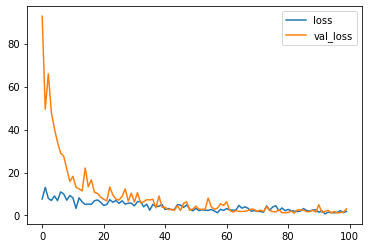

In [8]:
history = model.fit(test_it, validation_data=test_it, epochs=100)
df = pd.DataFrame(history.history)
df[['loss', 'val_loss']].plot()
plt.show()

In [23]:
model.save('manualmodel')

2022-03-05 11:06:49.174011: W tensorflow/python/util/util.cc:319] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: manualmodel/assets


In [ ]:
import keract
activations = keract.get_activations(model, test_it, auto_compile=True)
keract.display_activations(activations, cmap=None, save=False, directory='.', data_format='channels_last', fig_size=(24, 24), reshape_1d_layers=False)